In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import ta
import numpy as np
from Indicators import CustomIndocators as ci
from binance.client import Client
import tensorflow as tf

In [77]:
data=Client().get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, '01 January 2022')
df=pd.DataFrame(data,columns=["timestamp","open","high", "low", "close", "volume", "close_time", "quote_av", "trades", "tb_base_av", "tb_quote_av", "ignore"])

df = df.set_index(df['timestamp'])
df.index=pd.to_datetime(df.index, unit='ms')

del df['close_time']
del df['quote_av']
del df['trades']
del df['tb_base_av']
del df['tb_quote_av']
del df['ignore']

df

,timestamp,open,high,low,close,volume
timestamp,,,,,,
2022-01-01 00:00:00,1640995200000,46216.93000000,46731.39000000,46208.37000000,46656.13000000,1503.33095000
2022-01-01 01:00:00,1640998800000,46656.14000000,46949.99000000,46574.06000000,46778.14000000,943.81539000
2022-01-01 02:00:00,1641002400000,46778.14000000,46928.94000000,46721.96000000,46811.77000000,485.16860000
2022-01-01 03:00:00,1641006000000,46811.77000000,46916.63000000,46760.12000000,46813.20000000,562.88971000
2022-01-01 04:00:00,1641009600000,46813.21000000,46887.33000000,46591.23000000,46711.05000000,861.88389000
...,...,...,...,...,...,...
2022-03-21 09:00:00,1647853200000,41154.07000000,41358.03000000,41084.01000000,41330.38000000,1278.90359000
2022-03-21 10:00:00,1647856800000,41330.38000000,41442.70000000,41264.69000000,41332.32000000,963.20396000
2022-03-21 11:00:00,1647860400000,41332.32000000,41492.14000000,41178.25000000,41244.28000000,1349.74441000


In [78]:
df["open"] = df["open"].astype(float)
df["high"] = df["high"].astype(float)
df["low"] = df["low"].astype(float)
df["close"] = df["close"].astype(float)
df["volume"] = df["volume"].astype(float)

timestamp      int64
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object

In [79]:
def volume_anomality(df, volume_window):
        dfInd = df.copy()
        dfInd["VolAnomaly"] = 0
        dfInd["PreviousClose"] = dfInd["close"].shift(1)
        dfInd['MeanVolume'] = dfInd['volume'].rolling(volume_window).mean()
        dfInd['MaxVolume'] = dfInd['volume'].rolling(volume_window).max()
        dfInd.loc[dfInd['volume'] > 1.5 * dfInd['MeanVolume'], "VolAnomaly"] = 1
        dfInd.loc[dfInd['volume'] > 2 * dfInd['MeanVolume'], "VolAnomaly"] = 2
        dfInd.loc[dfInd['volume'] >= dfInd['MaxVolume'], "VolAnomaly"] = 3
        dfInd.loc[dfInd['PreviousClose'] > dfInd['close'],
                "VolAnomaly"] = (-1) * dfInd["VolAnomaly"]
        return dfInd["VolAnomaly"]

def buyCondition(row, previousRow):
    if (
        row['VOL_ANO'] > 0
        and previousRow['VOL_ANO'] < 0
        and previousRow['close'] <= previousRow['MIN20']
        and previousRow['CANDLE_DIFF'] > row['CANDLE_DIFF']
        and (previousRow['open'] - previousRow['close']) > 0.0025 * row['close']
    ):
        return True
    else:
        return False

# -- Condition to SELL market --
def sellCondition(row, x):
    if (
        row['WillR'] > -x
    ):
        return True
    else:
        return False

# -- Indicators, you can edit every value --
df['VOL_ANO'] = volume_anomality(df, 10)
df['MIN20'] = df['close'].rolling(20).min()
df['WillR'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=14)
df['CANDLE_DIFF'] = abs(df['open'] - df['close'])
df['MEAN_DIFF'] = df['CANDLE_DIFF'].rolling(10).mean()

In [97]:
def BackTesting(lbp, x, df):

    # -- Indicators, you can edit every value --
    df['VOL_ANO'] = volume_anomality(df, 10)
    df['MIN20'] = df['close'].rolling(20).min()
    df['WillR'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=lbp)
    df['CANDLE_DIFF'] = abs(df['open'] - df['close'])
    df['MEAN_DIFF'] = df['CANDLE_DIFF'].rolling(10).mean()

    dfTest=df[:]

    # -- Value initialisation --
    usd = startingBalance
    wallet = startingBalance
    coin = 0
    previousRow = dfTest.iloc[0]

    dfTrades = pd.DataFrame(columns=['date', 'position', 'reason','price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

    # -- Iteration on all your price dataset (df) --
    for index, row in dfTest.iterrows():
        # -- Buy market order --
        if buyCondition(row, previousRow) and usd > 0 :
            # -- You can define here at what price you buy --
            buyPrice = row['close']
            fee = takerFee * usd
            usd = usd - fee
            coin = usd / buyPrice
            usd = 0
            wallet = coin * row['close']

        # -- Sell Market Order --
        elif sellCondition(row, x):
            if coin > 0:
                # -- You can define here at what price you buy --
                sellPrice = row['close']
                usd = coin * sellPrice
                fee = takerFee * usd
                usd = usd - fee
                coin = 0
                wallet = usd
            
        previousRow = row
    return wallet



In [108]:
wallet=pd.DataFrame()
for i in range(14,50):
    for j in range(10,30):
        wallet=wallet.append({'lpb' : i,'x' : j, 'wallet' : BackTesting(i, j, df) } , ignore_index=True)

In [109]:
wallet["wallet"].max()

1523.9828419277976

In [110]:
x=0
lpb=0
for i in range(len(wallet)):
    if (wallet["wallet"][i]==wallet["wallet"].max()):
        lpb=wallet["lpb"][i]
        x=wallet["x"][i]
        print("lpb : "+str(lpb))
        print("x : "+str(x))

lpb : 44.0
x : 12.0


In [112]:
df['WillR'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=int(lpb))

# -- Intern parameter --
dfTest = df[:]
startingBalance = 1000
#makerFee = 0.0002
#takerFee = 0.0007
makerFee = 0
takerFee = 0


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
previousRow = dfTest.iloc[0]
Buy=pd.DataFrame(columns=['timestamp','close'])
Sell=pd.DataFrame(columns=['timestamp','close'])

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason','price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    # -- Buy market order --
    
    if buyCondition(row, previousRow) and usd > 0 :
        # -- You can define here at what price you buy --
        buyPrice = row['close']
        
        Buy=Buy.append({'timestamp' : row['timestamp'] , 'close' : row['close']} , ignore_index=True)
        
        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']
        
        print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)

    # -- Sell Market Order --
    elif sellCondition(row, x):
        buyReady = True
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            # buyReady = True
            wallet = usd
            
            Sell=Sell.append({'timestamp' : row['timestamp'] , 'close' : row['close']} , ignore_index=True)

            print("Sell COIN at", sellPrice, '$ the', index)

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
    previousRow = row

Buy = Buy.set_index(Buy['timestamp'])
Buy.index=pd.to_datetime(Buy.index, unit='ms')

Sell = Sell.set_index(Sell['timestamp'])
Sell.index=pd.to_datetime(Sell.index, unit='ms')

del Sell['timestamp']
del Buy['timestamp']

print("-----------------------------------------------------")
print("Final wallet", wallet)

Buy COIN at 40831.07 $ the 2022-01-08 19:00:00
Sell COIN at 42143.04 $ the 2022-01-09 16:00:00
Buy COIN at 40786.57 $ the 2022-01-10 14:00:00
Sell COIN at 42705.24 $ the 2022-01-11 16:00:00
Buy COIN at 42174.65 $ the 2022-01-17 18:00:00
Sell COIN at 42969.66 $ the 2022-01-20 14:00:00
Buy COIN at 35488.54 $ the 2022-01-22 10:00:00
Sell COIN at 36244.55 $ the 2022-01-23 23:00:00
Buy COIN at 33697.11 $ the 2022-01-24 11:00:00
Sell COIN at 36179.99 $ the 2022-01-24 18:00:00
Buy COIN at 41519.49 $ the 2022-02-06 15:00:00
Sell COIN at 42818.99 $ the 2022-02-07 03:00:00
Buy COIN at 44356.08 $ the 2022-02-10 14:00:00
Sell COIN at 45382.86 $ the 2022-02-10 16:00:00
Buy COIN at 42742.63 $ the 2022-02-11 19:00:00
Sell COIN at 43465.96 $ the 2022-02-15 01:00:00
Buy COIN at 40441.43 $ the 2022-02-18 12:00:00
Sell COIN at 39016.39 $ the 2022-02-23 12:00:00
Buy COIN at 35077.91 $ the 2022-02-24 04:00:00
Sell COIN at 39362.05 $ the 2022-02-25 12:00:00
Buy COIN at 37966.6 $ the 2022-02-27 20:00:00
Sell

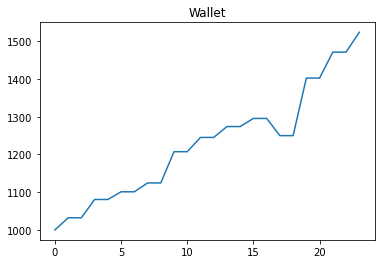

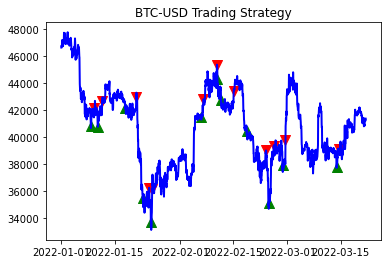

In [113]:
plt.figure()
plt.title('Wallet')
plt.plot(dfTrades["wallet"])
plt.figure()
plt.title('BTC-USD Trading Strategy')
plt.plot(df["close"], color='b', lw=2.)
plt.scatter(Buy.index,Buy['close'],marker = '^', color='g', s=100 )
plt.scatter(Sell.index,Sell['close'],marker = 'v', color='r', s=100)